In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when
spark = SparkSession.builder.appName("SamsungStockClean").getOrCreate()
import pandas as pd
from pyampute.exploration.mcar_statistical_tests import MCARTest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates

In [11]:
#Load data
ss = spark.read.csv("./Samsung Electronics Stock Historical Price.csv", header=True, inferSchema=True)
ss.printSchema()
ss.describe().show()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|              Open|              High|              Low|             Close|         Adj Close|              Volume|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|  count|              1505|              1505|             1505|              1505|              1505|                1505|
|   mean|64154.617940199336| 64734.01993355482|63548.70431893688| 64108.90365448505| 59933.01363164452|1.6625267806644518E7|
| stddev|12269.830762688787|12321.091698838984|12176.81337181051|12227.346772831712|12894.680103072302|   87315

In [12]:
#Load KOSPI data
kospi = spark.read.csv("./KOSPI Data.csv", header=True, inferSchema=True)
kospi.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Vol.: string (nullable = true)
 |-- Change %: string (nullable = true)



In [13]:
ss.dtypes

[('Date', 'date'),
 ('Open', 'double'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Close', 'double'),
 ('Adj Close', 'double'),
 ('Volume', 'int')]

In [14]:
# Count missing values in each column
missing = {col_name: ss.filter(col(col_name).isNull()).count() for col_name in ss.columns}
print(missing)
# Because the data of the stock price is updated every day, there is no missing value in the data.

{'Date': 0, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 0, 'Volume': 0}


In [15]:
# Check for duplicate rows
duplicates = ss.groupBy(ss.columns).count().filter(col("count") > 1)
print("Number of duplicate rows:", duplicates.count())
duplicates.show()

Number of duplicate rows: 0
+----+----+----+---+-----+---------+------+-----+
|Date|Open|High|Low|Close|Adj Close|Volume|count|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+



In [16]:
# Check if 'Open' or 'Close' is less than 'Low'
lower_than_low = ss.filter((col("Open") < col("Low")) | (col("Close") < col("Low")))
print("Số lần 'Open' hoặc 'Close' thấp hơn 'Low':", lower_than_low.count())
lower_than_low.show()
# Fix incorrect data: if 'Low' < 'Close', set 'Low' to 'Close'
ss_fixed = ss.withColumn("Low", when(col("Low") < col("Close"), col("Close")).otherwise(col("Low")))

ss_fixed.orderBy("Date").show(5)


Số lần 'Open' hoặc 'Close' thấp hơn 'Low': 1
+----------+-------+-------+-------+-------+-------------+--------+
|      Date|   Open|   High|    Low|  Close|    Adj Close|  Volume|
+----------+-------+-------+-------+-------+-------------+--------+
|2024-10-14|59500.0|61200.0|59400.0|59300.0|58898.3984375|20886249|
+----------+-------+-------+-------+-------+-------------+--------+

+----------+-------+-------+-------+-------+---------------+--------+
|      Date|   Open|   High|    Low|  Close|      Adj Close|  Volume|
+----------+-------+-------+-------+-------+---------------+--------+
|2019-01-02|39400.0|39400.0|38750.0|38750.0| 33061.84765625| 7847664|
|2019-01-03|38300.0|38550.0|37600.0|37600.0|32080.662109375|12471493|
|2019-01-04|37450.0|37600.0|37450.0|37450.0| 31952.66796875|14108958|
|2019-01-07|38000.0|38900.0|38750.0|38750.0| 33061.84765625|12748997|
|2019-01-08|38000.0|39200.0|38100.0|38100.0|32507.259765625|12756554|
+----------+-------+-------+-------+-------+----------

In [17]:
# Convert spark DataFrame to Pandas DataFrame
ss_pd = ss_fixed.toPandas()
kospi_pd = kospi.toPandas()

In [18]:
#Stop Spark session
spark.stop()

### **1. Data Analysis**

##### Candle chart of 200 days nearest


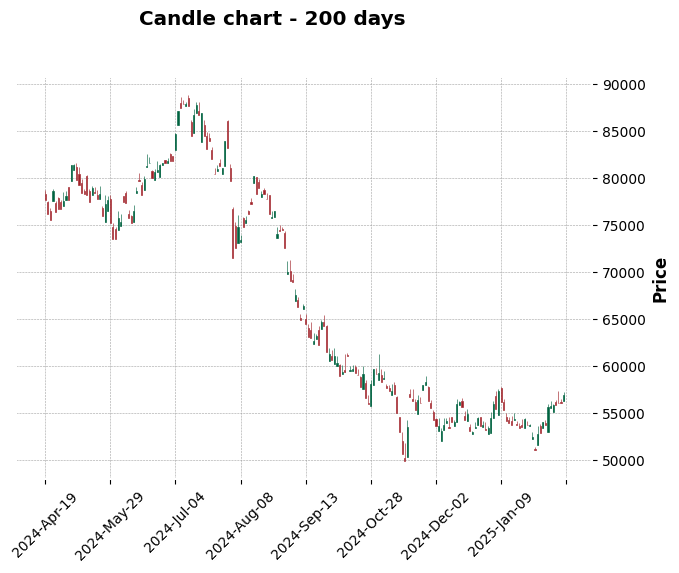

In [10]:
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_candle = ss_pd[['Date', 'Open', 'High', 'Low', 'Close']].copy()
ss_candle.set_index('Date', inplace=True)

mpf.plot(ss_candle[-200:], type='candle', style='charles', title='Candle chart - 200 days')


##### Samsung versus KOSPI cumulative daily return

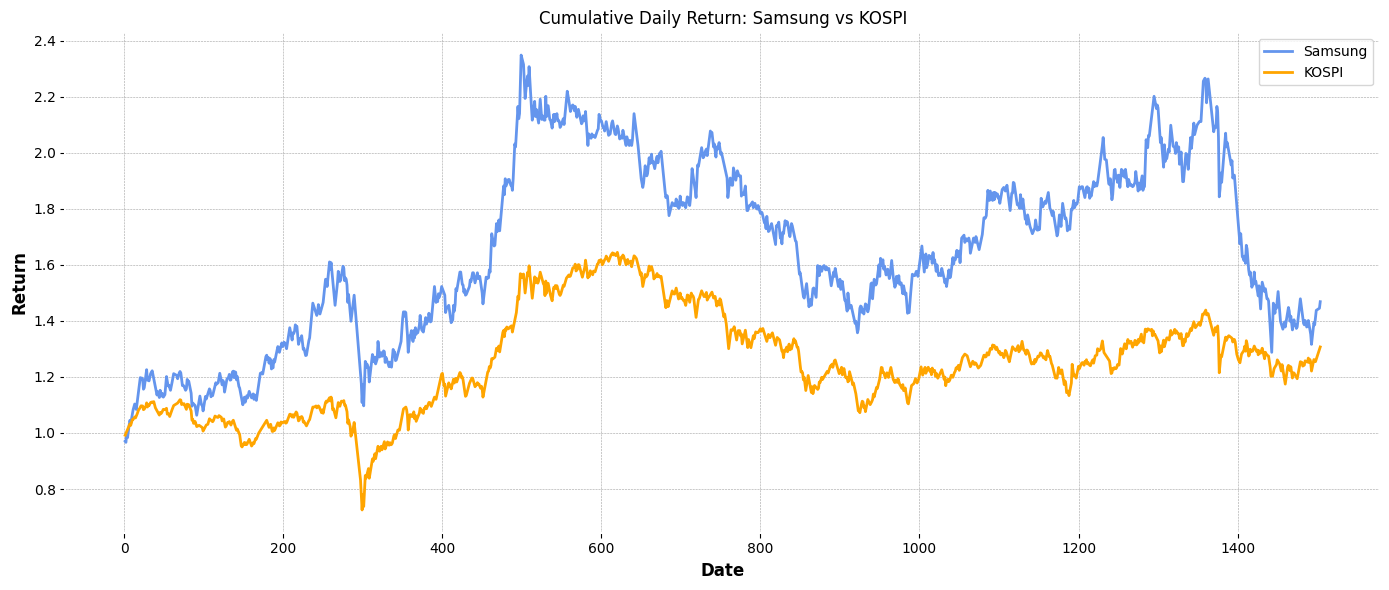

In [12]:
# Calculate daily returns 
ss_pd['Return'] = ss_pd['Close'].pct_change()
kospi_pd['Price'] = pd.to_numeric(kospi_pd['Price'].str.replace(',', ''), errors='coerce')
kospi_pd['Return'] = kospi_pd['Price'].pct_change()
# Merge two dataframes on Date index
returns = pd.merge(
    ss_pd[['Return']], 
    kospi_pd[['Return']], 
    left_index=True, 
    right_index=True, 
    suffixes=('_Samsung', '_KOSPI')
)
# Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns.index, cumulative_returns['Return_Samsung'], label='Samsung', color='cornflowerblue')
plt.plot(cumulative_returns.index, cumulative_returns['Return_KOSPI'], label='KOSPI', color='orange')
plt.title("Cumulative Daily Return: Samsung vs KOSPI")
plt.ylabel("Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Return Distribution

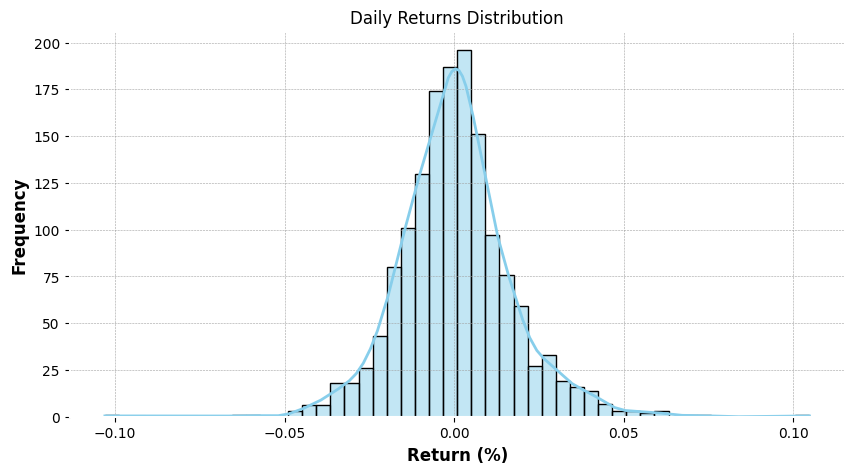

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(ss_pd['Return'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Daily Returns Distribution')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.show()

##### Trend Analysis

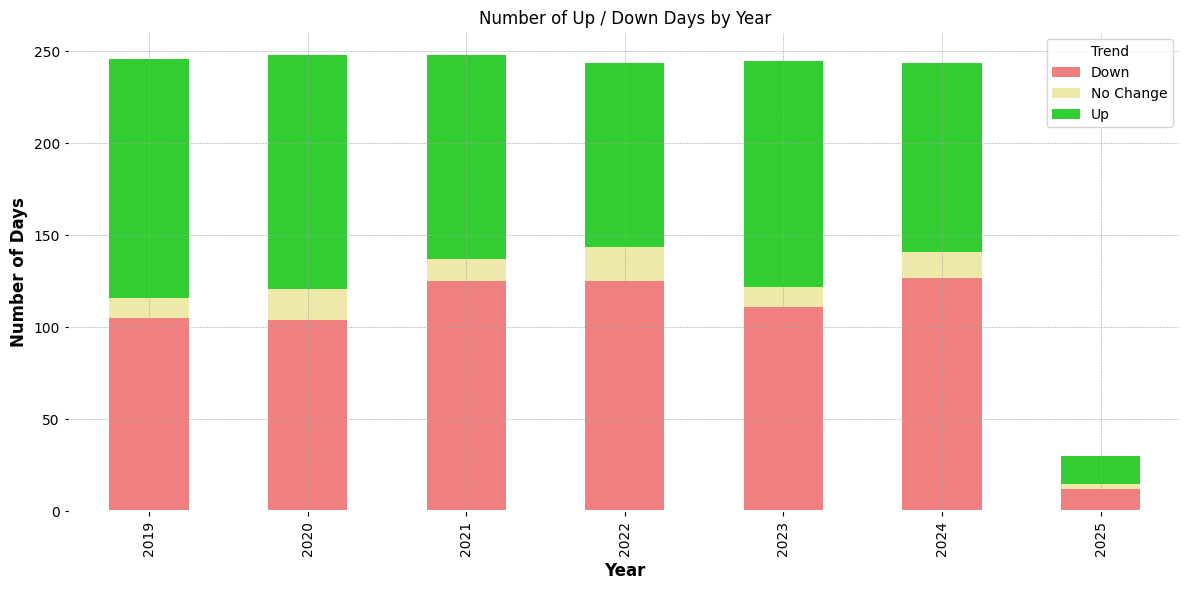

In [15]:
# Label the trend
ss_pd['Trend'] = np.where(ss_pd['Return'] > 0, 'Up', 
                       np.where(ss_pd['Return'] < 0, 'Down', 'No Change'))

ss_pd['Year'] = ss_pd['Date'].dt.year
trend_by_year = ss_pd.groupby(['Year', 'Trend']).size().unstack(fill_value=0)

colors = {
    'Up': 'limegreen',
    'Down': 'lightcoral',
    'No Change': 'palegoldenrod'
}
trend_by_year.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors[col] for col in trend_by_year.columns])
plt.title('Number of Up / Down Days by Year')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.legend(title='Trend')
plt.tight_layout()
plt.show()

##### Stock Price & Trading Volume with SMA (20/50)

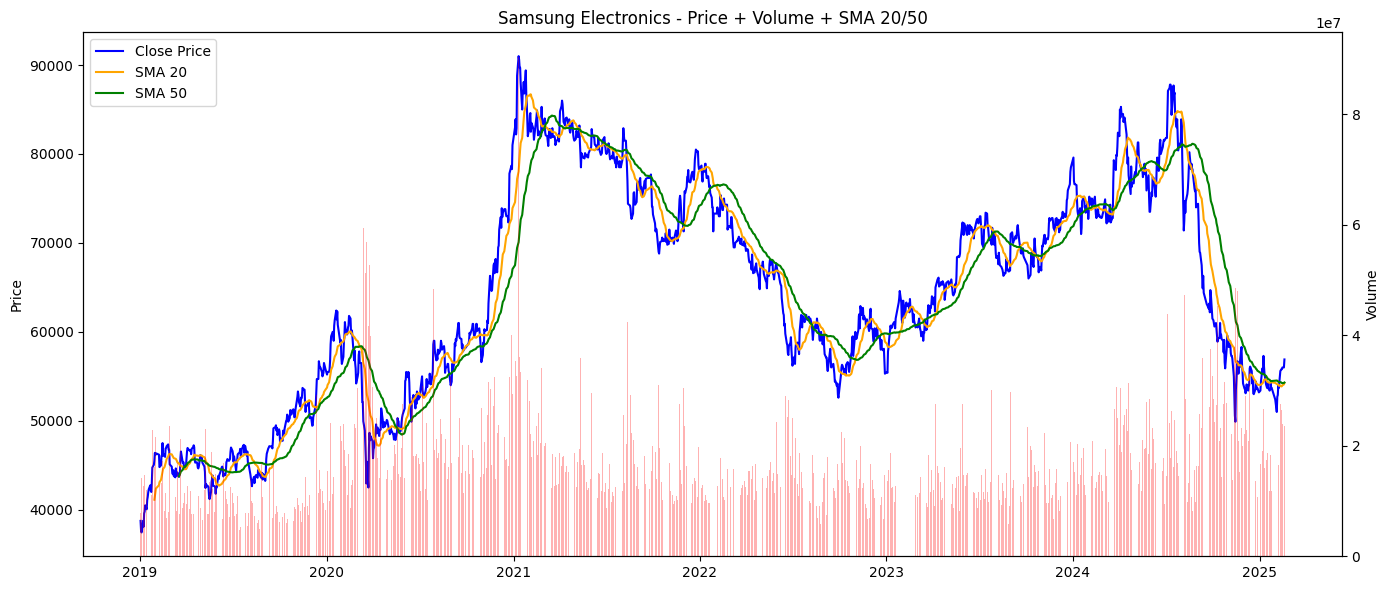

In [19]:
# Đọc dữ liệu
df = ss_pd.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Tính SMA 20 và SMA 50
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df['Date'], df['Close'], label='Close Price', color='blue')
ax1.plot(df['Date'], df['SMA20'], label='SMA 20', color='orange')
ax1.plot(df['Date'], df['SMA50'], label='SMA 50', color='green')
ax1.set_ylabel('Price')
ax1.tick_params(axis='y')

# Vẽ biểu đồ Volume
ax2 = ax1.twinx()
ax2.bar(df['Date'], df['Volume'], color='red', alpha=0.3)
ax2.set_ylabel('Volume')
ax2.tick_params(axis='y')

# Định dạng thời gian
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Samsung Electronics - Price + Volume + SMA 20/50')
ax1.legend(loc='upper left')
fig.tight_layout()
plt.show()


##### Trading Volume with VMA (20/50)

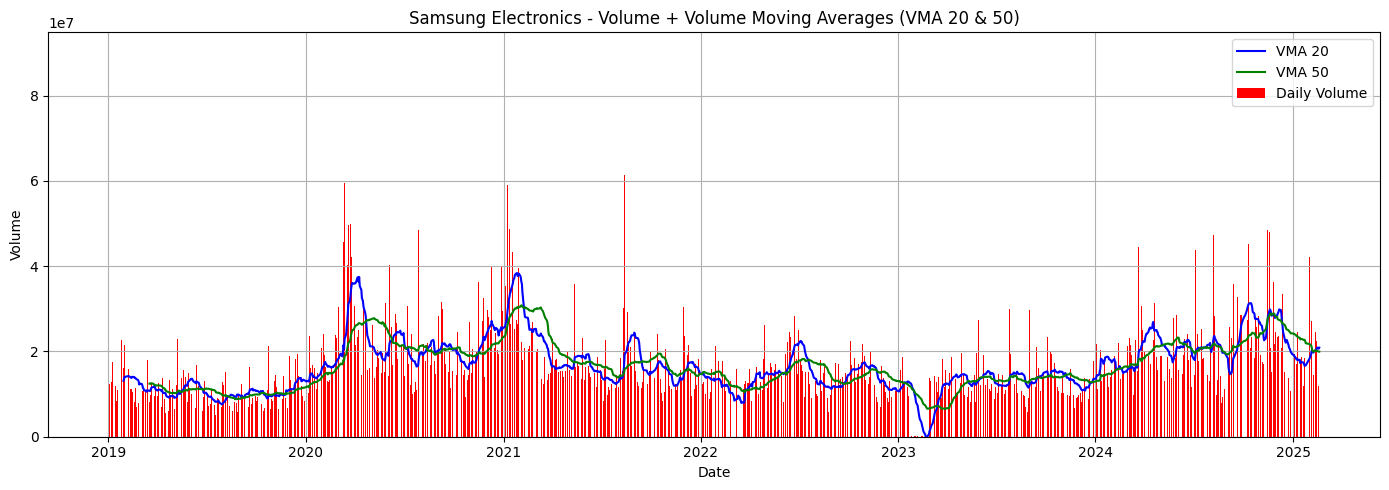

In [20]:
# Đọc dữ liệu
df = ss_pd.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Tính SMA cho Volume (VMA)
df['VMA20'] = df['Volume'].rolling(window=20).mean()
df['VMA50'] = df['Volume'].rolling(window=50).mean()

# Vẽ biểu đồ Volume + VMA
plt.figure(figsize=(14, 5))
plt.bar(df['Date'], df['Volume'], color='red', label='Daily Volume')
plt.plot(df['Date'], df['VMA20'], color='blue', label='VMA 20')
plt.plot(df['Date'], df['VMA50'], color='green', label='VMA 50')

plt.title("Samsung Electronics - Volume + Volume Moving Averages (VMA 20 & 50)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)

# Định dạng trục thời gian
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

